In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#lineer regresyon uygulayacağım verisetime eriştim.
df = pd.read_excel("DATASET_LASTFORM.xlsx")

In [3]:
#Bu liste modelde kullanmak istediğim sütunları içeriyor.
columns_to_use = [
    #Tahmin etmek istediğim hedef sütunlar:
    'durationInMs', 'copyDuration', 'durationInQueue', 'queueDuration',
    'transferDuration', 'totalDuration', 'throughput',

    #Sayısal özellikler:
    'dataRead', 'dataWritten', 'billableDuration', 'rowsCopied', 'rowsRead',
    'totalBillableDuration', 'queuingDuration', 'timeToFirstByte',
    'interimDataWritten', 'interimRowsCopied',
    'sinkPeakConnections', 'sourcePeakConnections',

    #Kategorik özellikler:
    'activityName', 'activityRunEnd', 'activityRunId', 'activityRunStart',
    'activityType', 'pipelineName', 'pipelineRunId', 'status',
    'billable_meterType', 'billable_unit', 'totalBillable_meterType',
    'totalBillable_unit', 'dataConsistencyVerification',
    'effectiveIntegrationRuntime', 'queueStatus',
    'integrationRuntime_name', 'integrationRuntime_type',
    'integrationRuntime_location', 'integrationRuntimeName'
]

#Veriyi sadece belirlenen sütunlarla filtreleyip ve eksik değerleri attım.
df = df[columns_to_use].dropna()

#Kategorik sütunlar
categorical_features = [
    'activityName', 'activityRunEnd', 'activityRunId', 'activityRunStart',
    'activityType', 'pipelineName', 'pipelineRunId', 'status',
    'billable_meterType', 'billable_unit', 'totalBillable_meterType',
    'totalBillable_unit', 'dataConsistencyVerification',
    'effectiveIntegrationRuntime', 'queueStatus',
    'integrationRuntime_name', 'integrationRuntime_type',
    'integrationRuntime_location', 'integrationRuntimeName'
]

#Sayısal sütunlar
numerical_features = [col for col in df.columns if col not in categorical_features + [
    'durationInMs', 'copyDuration', 'durationInQueue', 'queueDuration',
    'transferDuration', 'totalDuration', 'throughput'
]]

#Bağımlı değişkenler (tahmin etmek istediklerim)
target_columns = [
    'durationInMs', 'copyDuration', 'durationInQueue', 'queueDuration',
    'transferDuration', 'totalDuration', 'throughput'
]

# X ve y'yi ayırıyorum.
X = df.drop(columns=target_columns)
y = df[target_columns]


In [4]:
#Ön işleme: Sayısal + Kategorik sütunları dönüştürüyorum.
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("num", StandardScaler(), numerical_features)
])

#7 süre sütununu aynı anda tahmin etmek için multi-output regresyon kullandım.
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", MultiOutputRegressor(LinearRegression()))
])

#Eğitim/test bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Modeli eğit
pipeline.fit(X_train, y_train)

#Tahmin yap
y_pred = pipeline.predict(X_test)


In [5]:
#Sadece ilk örneği aldım.
rows = []

i = 0  # 0. örnek

for col in y.columns:
    rows.append({
        "Sütun": col,
        "Gerçek Değer": round(y_test.iloc[i][col], 2),
        "Tahmin Değeri": round(y_pred[i][y.columns.get_loc(col)], 2)
    })

# DataFrame olarak yazdır
prediction_df = pd.DataFrame(rows)
print("Tek Örnek İçin Tahmin Sonuçları:")
print(prediction_df)


Tek Örnek İçin Tahmin Sonuçları:
              Sütun  Gerçek Değer  Tahmin Değeri
0      durationInMs    1261651.00     1153522.09
1      copyDuration       1257.00        1246.81
2   durationInQueue       1230.00        1210.96
3     queueDuration       1229.00        1214.32
4  transferDuration         20.00          21.37
5     totalDuration       1257.00        1243.95
6        throughput        391.25         531.92


In [6]:
#Performans metrikleri
print("Her Süre Sütunu İçin Performans Skorları:\n")

for i, col in enumerate(y.columns):
    y_true = y_test[col].values
    y_pred_col = y_pred[:, i]

    mse = mean_squared_error(y_true, y_pred_col)
    mae = mean_absolute_error(y_true, y_pred_col)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred_col)
    mean_actual = np.mean(y_true)
    mae_percent = (mae / mean_actual) * 100 if mean_actual != 0 else 0

    print(f"{col}:")
    print(f"  MSE   : {round(mse, 2)}") #Ortalama kare hatası, büyükse büyük hata
    print(f"  MAE   : {round(mae, 2)}")  #Ortalama mutlak hata, küçükse doğru tahmin
    print(f"  MAE (%) : {round(mae_percent, 2)}%") # MAE yüzdelik hata oranı
    print(f"  RMSE  : {round(rmse, 2)}") #Kök ortalama kare hatası, küçükse doğru tahmin
    print(f"  R²    : {round(r2, 4)}\n") #R-kare (modelin doğruluğu), 1'e yakınsa doğru tahmin


Her Süre Sütunu İçin Performans Skorları:

durationInMs:
  MSE   : 83705752346.15
  MAE   : 131377.99
  MAE (%) : 27.29%
  RMSE  : 289319.46
  R²    : 0.6362

copyDuration:
  MSE   : 259.4
  MAE   : 9.43
  MAE (%) : 1.72%
  RMSE  : 16.11
  R²    : 0.9989

durationInQueue:
  MSE   : 62.85
  MAE   : 4.11
  MAE (%) : 0.82%
  RMSE  : 7.93
  R²    : 0.9997

queueDuration:
  MSE   : 15.09
  MAE   : 2.82
  MAE (%) : 0.56%
  RMSE  : 3.88
  R²    : 0.9999

transferDuration:
  MSE   : 119.94
  MAE   : 7.65
  MAE (%) : 22.54%
  RMSE  : 10.95
  R²    : 0.9903

totalDuration:
  MSE   : 146.85
  MAE   : 8.58
  MAE (%) : 1.57%
  RMSE  : 12.12
  R²    : 0.9994

throughput:
  MSE   : 29191.11
  MAE   : 73.14
  MAE (%) : 86.03%
  RMSE  : 170.85
  R²    : 0.7582



In [7]:
#duration sütunları
duration_columns = [
    'durationInMs', 'copyDuration', 'durationInQueue',
    'queueDuration', 'transferDuration', 'totalDuration',
    'throughput'
]

clean_indices = set(df.index)  #önce tüm indeksler

#Optimizasyon -Aykırı değer temizliği
for target_col in duration_columns:
    Q1 = df[target_col].quantile(0.25)
    Q3 = df[target_col].quantile(0.75)
    IQR = Q3 - Q1
    mask = (df[target_col] >= Q1 - 1.5 * IQR) & (df[target_col] <= Q3 + 1.5 * IQR)  #Aykırı olmayan veriler için maske
    clean_indices = clean_indices.intersection(df[mask].index) #ortak satırları tutuyorum

#Ortak aykırı olmayan satırları filtreliyorum
df_filtered = df.loc[list(clean_indices)]

# Bağımlı ve bağımsız değişkenler
y_filtered = df_filtered[duration_columns]
X_filtered = df_filtered.drop(columns=duration_columns)


In [8]:
#VIF, bir bağımsız değişkenin diğer bağımsız değişkenlerle olan doğrusal ilişkisini ölçen bir metriktir.
#VIF > 10: Çoklu doğrusal ilişki var, model güvenilirliği düşebilir. 10'dan büyük olanlar silinmeli
warnings.filterwarnings("ignore", category=RuntimeWarning)

#Sadece sayısal sütunları alıyorum.
numeric_cols = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numeric_cols]

#Sabit sütun ekliyorum.
X_const = add_constant(X_numeric)

#VIF değerlerini hesaplanması (sabit hariç)
vif_values = []
valid_columns = []

for i in range(1, X_const.shape[1]):  #0 sabit (const) olduğu için 1'den başlayacak.
    try:
        vif = variance_inflation_factor(X_const.values, i)
        if np.isfinite(vif):  # NaN veya sonsuz değilse
            vif_values.append(vif)
            valid_columns.append(X_numeric.columns[i-1])
    except Exception:
        continue  # Hata olursa atla

#Sonuçları DataFrame olarak yazdırıyorum.
vif_data = pd.DataFrame({
    "feature": valid_columns,
    "VIF": vif_values
})

print("Geçerli VIF Değerleri:")
print(vif_data.sort_values(by="VIF", ascending=False))

Geçerli VIF Değerleri:
                 feature           VIF
2               rowsRead  17785.838138
3  totalBillableDuration      4.329502
1       billableDuration      3.332055
0               dataRead      2.558273
4        queuingDuration      1.503939
6    sinkPeakConnections      1.408737
5        timeToFirstByte      1.174759
7  sourcePeakConnections      1.004240


In [9]:
#rowsRead sütununu çıkarıyorum.(VIF = 17785.83)
X = X.drop(columns=['rowsRead'])

#Test setinden de çıkarıyorum.
X_test = X_test.drop(columns=['rowsRead'])

#rowsRead'i numerical_features listesinden de çıkarardım.
numerical_features = [col for col in numerical_features if col != 'rowsRead']


In [10]:
#Kategorik ve sayısal sütunların tespiti
categorical_features = X_filtered.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X_filtered.select_dtypes(include=[np.number]).columns.tolist()

#Veriyi eğitim ve test olarak %75-%25 oranında bölüyorum.
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.25, random_state=42
)

#Ön işleme adımı: Kategorik değişkenler one-hot encode, sayısal değişkenler standardizasyon
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("num", StandardScaler(), numerical_features)
])

#7 süre sütununu aynı anda tahmin etmek için multi-output regresyon kullandım.
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", MultiOutputRegressor(LinearRegression()))
])

#Model eğitimi
pipeline.fit(X_train, y_train)

#Tahmin
y_pred = pipeline.predict(X_test)


In [11]:
#İlk örnek için gerçek ve tahmin değerlerini gösterdim.
i = 0  # ilk satır

rows = []
for col in y.columns:
    rows.append({
        "Sütun": col,
        "Gerçek Değer": round(y_test.iloc[i][col], 2),
        "Tahmin Değeri": round(y_pred[i][y.columns.get_loc(col)], 2)
    })

prediction_df = pd.DataFrame(rows)
print("İlk Örnek İçin Tahmin Sonuçları:")
print(prediction_df)


İlk Örnek İçin Tahmin Sonuçları:
              Sütun  Gerçek Değer  Tahmin Değeri
0      durationInMs    1189500.00      633990.52
1      copyDuration       1182.00        1182.19
2   durationInQueue       1156.00        1157.37
3     queueDuration       1159.00        1157.36
4  transferDuration         15.00          16.26
5     totalDuration       1182.00        1182.19
6        throughput          0.03           0.00


In [12]:
#Performans metrikleri
print("Her Süre Sütunu İçin Performans Skorları:\n")

for i, col in enumerate(y.columns):
    y_true = y_test[col].values
    y_pred_col = y_pred[:, i]

    mse = mean_squared_error(y_true, y_pred_col)
    mae = mean_absolute_error(y_true, y_pred_col)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred_col)
    mean_actual = np.mean(y_true)
    mae_percent = (mae / mean_actual) * 100 if mean_actual != 0 else 0

    print(f"{col}:")
    print(f"  MSE   : {round(mse, 2)}") #Ortalama kare hatası, büyükse büyük hata
    print(f"  MAE   : {round(mae, 2)}")  #Ortalama mutlak hata, küçükse doğru tahmin
    print(f"  MAE (%) : {round(mae_percent, 2)}%") # MAE yüzdelik hata oranı
    print(f"  RMSE  : {round(rmse, 2)}") #Kök ortalama kare hatası, küçükse doğru tahmin
    print(f"  R²    : {round(r2, 4)}\n") #R-kare (modelin doğruluğu), 1'e yakınsa doğru tahmin


Her Süre Sütunu İçin Performans Skorları:

durationInMs:
  MSE   : 54331313246.54
  MAE   : 110039.9
  MAE (%) : 25.77%
  RMSE  : 233090.78
  R²    : 0.7501

copyDuration:
  MSE   : 113.71
  MAE   : 7.03
  MAE (%) : 1.49%
  RMSE  : 10.66
  R²    : 0.9995

durationInQueue:
  MSE   : 105.37
  MAE   : 5.13
  MAE (%) : 1.16%
  RMSE  : 10.26
  R²    : 0.9995

queueDuration:
  MSE   : 27.58
  MAE   : 3.63
  MAE (%) : 0.82%
  RMSE  : 5.25
  R²    : 0.9999

transferDuration:
  MSE   : 91.43
  MAE   : 5.89
  MAE (%) : 43.58%
  RMSE  : 9.56
  R²    : 0.4975

totalDuration:
  MSE   : 115.17
  MAE   : 7.04
  MAE (%) : 1.49%
  RMSE  : 10.73
  R²    : 0.9995

throughput:
  MSE   : 2.11
  MAE   : 0.67
  MAE (%) : 57.09%
  RMSE  : 1.45
  R²    : 0.5643



In [13]:
# Tahmin edilecek sütunlar(hedef)
target_cols = [
    'durationInMs', 'copyDuration', 'durationInQueue', 'queueDuration',
    'transferDuration', 'totalDuration', 'throughput'
]

# Bağımlı değişken y
y = df[target_cols]

# Bağımsız değişken X: hedef sütunları çıkarıyorum.
X = df.drop(columns=target_cols)

# Kategorik ve sayısal sütunları ayrılması (X içerisinden)
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

#Örnek veri (sample_data) sadece X sütunlarından oluşmalı
sample_data = {
    # Kategorik sütunlar örnek değerleri
    'activityName': 'Copy data1',
    'activityRunEnd': '2025-06-09T21:08:18.8127192Z',
    'activityRunId': '7b9b8a0c-91d8-4d37-94b9-720ffcc5c7bb',
    'activityRunStart': '2025-06-09T21:07:52.6528533Z',
    'activityType': 'Copy',
    'pipelineName': 'P_GBQ_MTA_METRICS_ALL',
    'pipelineRunId': '57e08b3f-3c7c-4aea-aca6-d274979c413c',
    'status': 'Succeeded',
    'billable_meterType': 'AzureIR',
    'billable_unit': 'DIUHours',
    'totalBillable_meterType': 'AzureIR',
    'totalBillable_unit': 'DIUHours',
    'dataConsistencyVerification': 'NotVerified',
    'effectiveIntegrationRuntime': 'AutoResolveIntegrationRuntime (West Europe)',
    'queueStatus': 'Completed',
    'integrationRuntime_name': 'AutoResolveIntegrationRuntime',
    'integrationRuntime_type': 'Managed',
    'integrationRuntime_location': 'West Europe',
    'integrationRuntimeName': 'autoresolveintegrationruntime',

    # Sayısal sütunlar örnek değerleri
    'dataRead': 63396,
    'dataWritten': 65556,
    'queuingDuration': 5,
    'billableDuration': 0.0666666666666667,
    'rowsCopied': 270,
    'totalBillableDuration': 0.0666666666666667,
    'timeToFirstByte': 0,
    'interimDataWritten': 65556,
    'interimRowsCopied': 270,
    'sinkPeakConnections': 2,
    'sourcePeakConnections': 1
}

#Sample DataFrame oluşturrulması
sample_df = pd.DataFrame([sample_data])

#Eksik sütunları doldurulması (X sütunlarından sample_df'de olmayan varsa)
for col in X.columns:
    if col not in sample_df.columns:
        sample_df[col] = 'Hayır' if col in categorical_features else 0

#Sütun sırasını X ile aynı yapılması
sample_df = sample_df[X.columns]

#Ön işleme pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MultiOutputRegressor(LinearRegression()))
])

#Eğitim ve test bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Modeli eğit
pipeline.fit(X_train, y_train)

#Sample veri için tahmin yaptırıyorum.
predicted = pipeline.predict(sample_df)

print("Sample veri için tahmin edilen değerler:")
for i, col in enumerate(target_cols):
    print(f"{col}: {predicted[0][i]:.2f}")

gercek_degerler = {
    'durationInMs': 26159,
    'copyDuration': 23,
    'durationInQueue': 0,
    'queueDuration': 5,
    'transferDuration': 14,
    'totalDuration': 23,
    'throughput': 4.528
}

print("Gerçek Değerlerle Karşılaştırma:")
for i, col in enumerate(target_cols):
    print(f"{col:<20} Tahmin: {predicted[0][i]:>8.2f}  |  Gerçek: {gercek_degerler[col]:>8}")


Sample veri için tahmin edilen değerler:
durationInMs: 26167.38
copyDuration: 22.99
durationInQueue: -0.01
queueDuration: 5.00
transferDuration: 14.00
totalDuration: 22.99
throughput: 4.56
Gerçek Değerlerle Karşılaştırma:
durationInMs         Tahmin: 26167.38  |  Gerçek:    26159
copyDuration         Tahmin:    22.99  |  Gerçek:       23
durationInQueue      Tahmin:    -0.01  |  Gerçek:        0
queueDuration        Tahmin:     5.00  |  Gerçek:        5
transferDuration     Tahmin:    14.00  |  Gerçek:       14
totalDuration        Tahmin:    22.99  |  Gerçek:       23
throughput           Tahmin:     4.56  |  Gerçek:    4.528


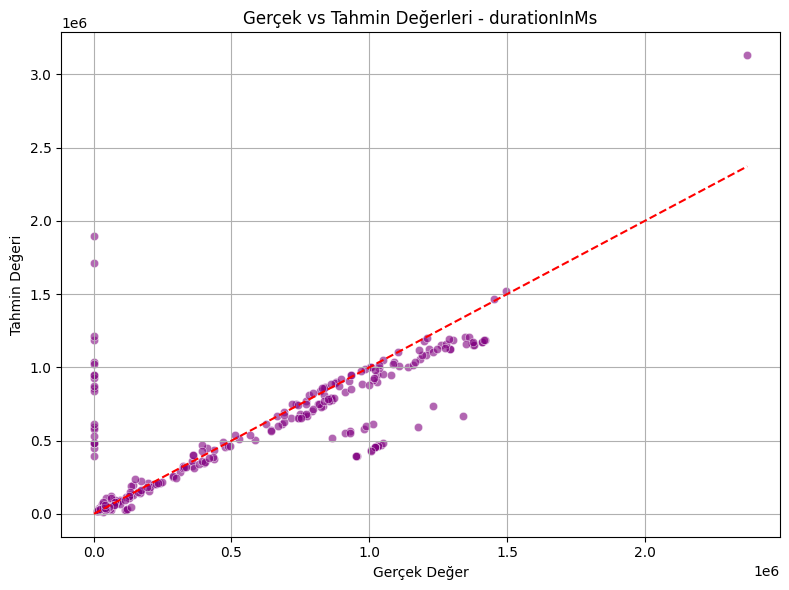

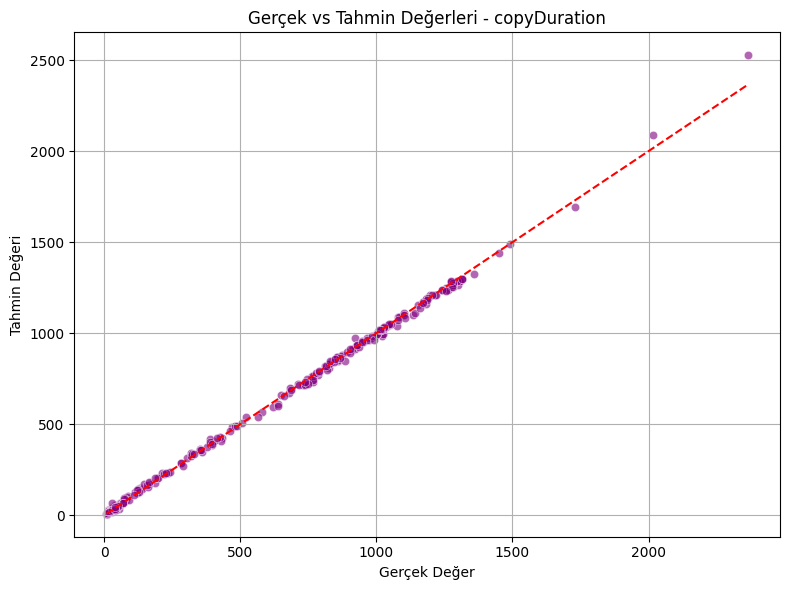

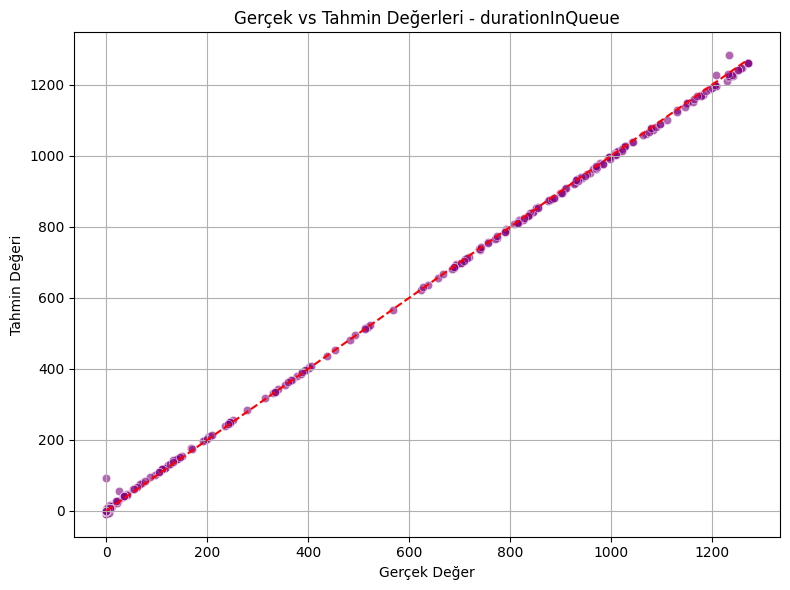

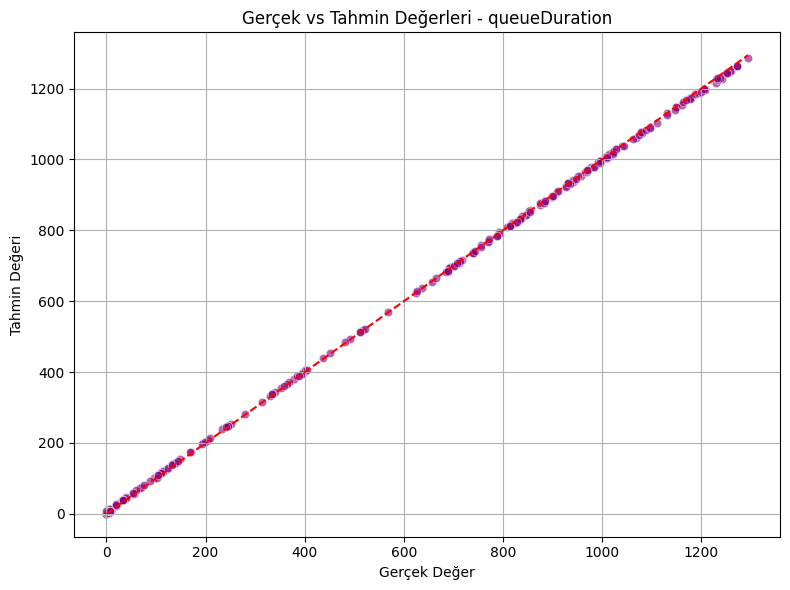

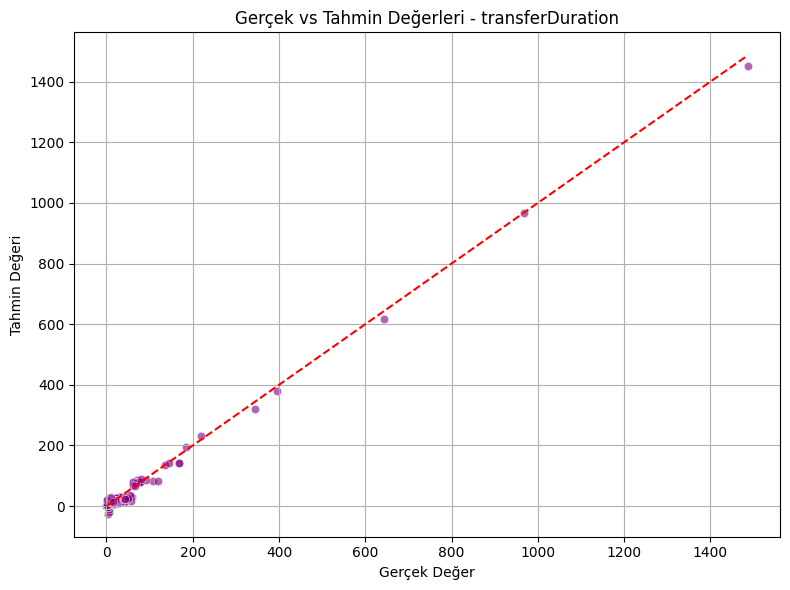

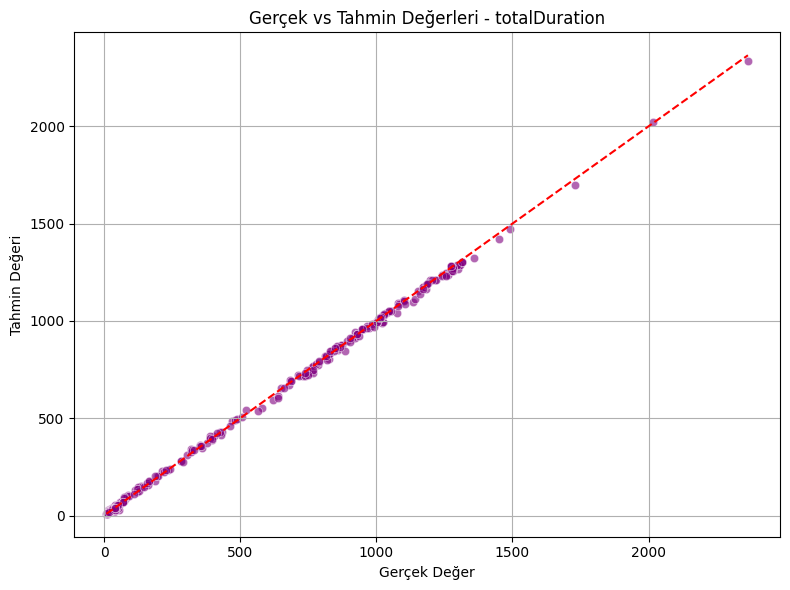

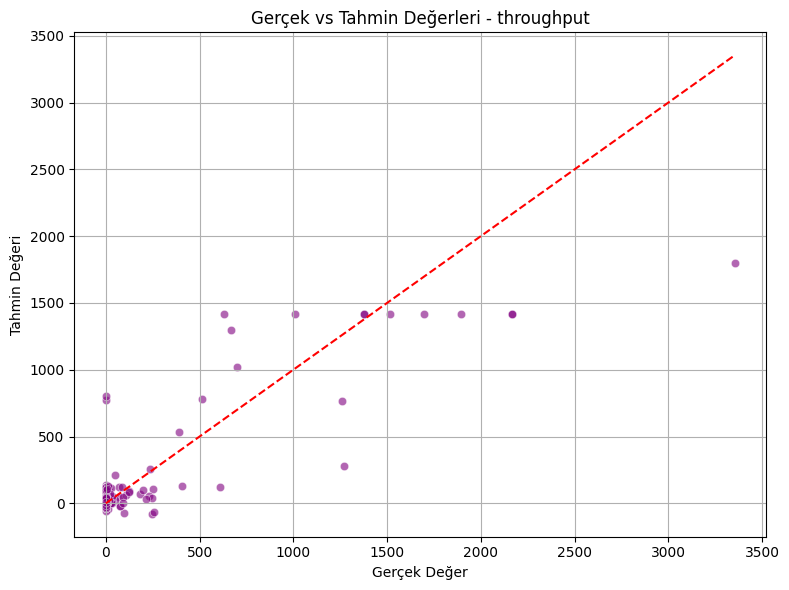

In [14]:
#duration sütunları
target_columns = ['durationInMs', 'copyDuration', 'durationInQueue', 'queueDuration', 'transferDuration', 'totalDuration', 'throughput']

# İndeksleri sıfırlıyorum ki uyumsuzluk olmasın.
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#Tahmin yap
y_pred = pipeline.predict(X_test)

#Tahminleri dataFrame yapıyorum.
y_pred_df = pd.DataFrame(y_pred, columns=target_columns)

#scatter plot çizimi
for col in target_columns:
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=y_test[col], y=y_pred_df[col], alpha=0.6, color='purple')
    plt.plot([y_test[col].min(), y_test[col].max()], [y_test[col].min(), y_test[col].max()], 'r--')
    plt.xlabel("Gerçek Değer")
    plt.ylabel("Tahmin Değeri")
    plt.title(f"Gerçek vs Tahmin Değerleri - {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Tahmin vs Gerçek değerleri karşılaştıran bir saçılım grafiği oluşturur.

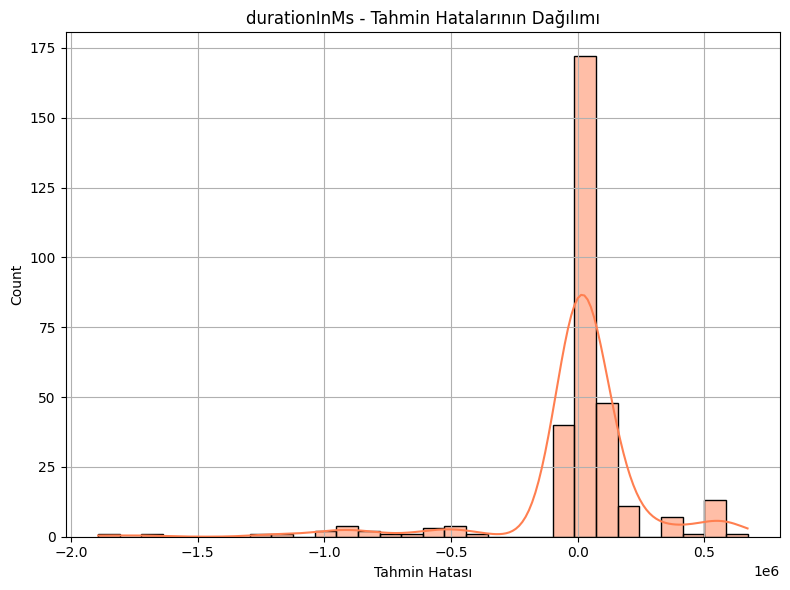

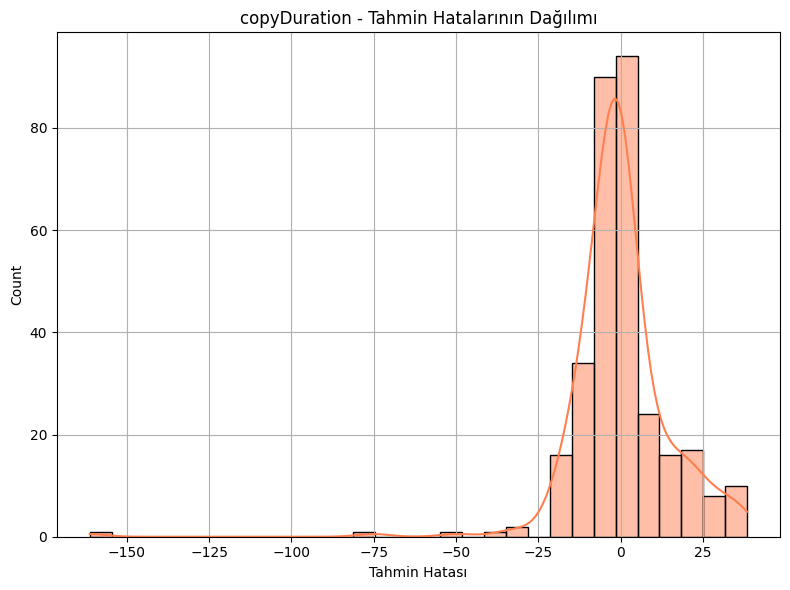

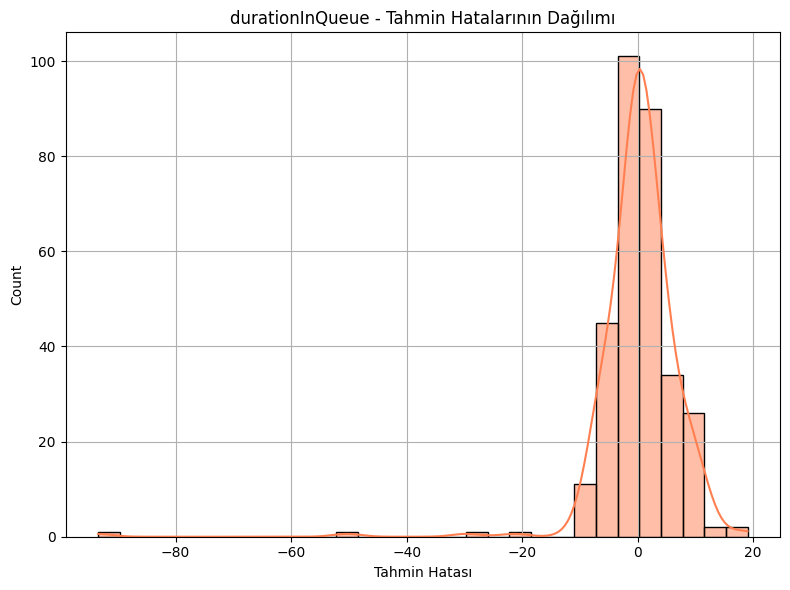

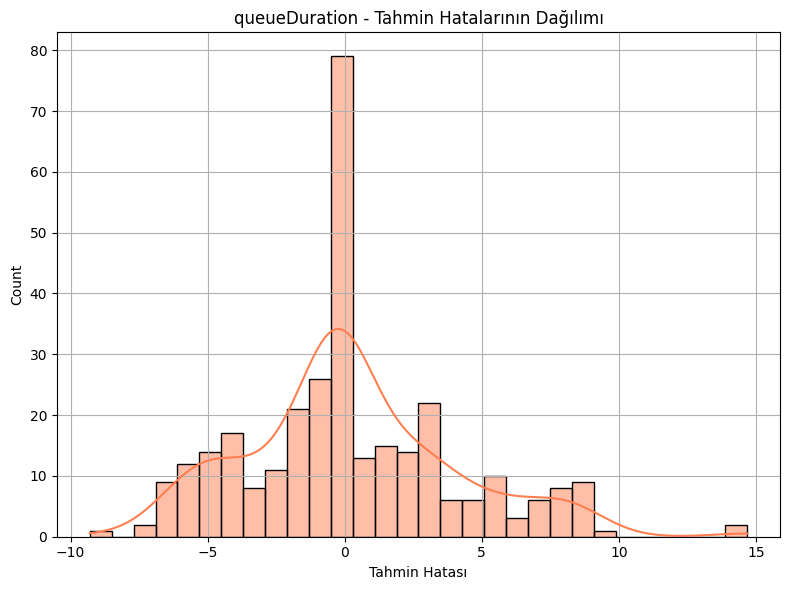

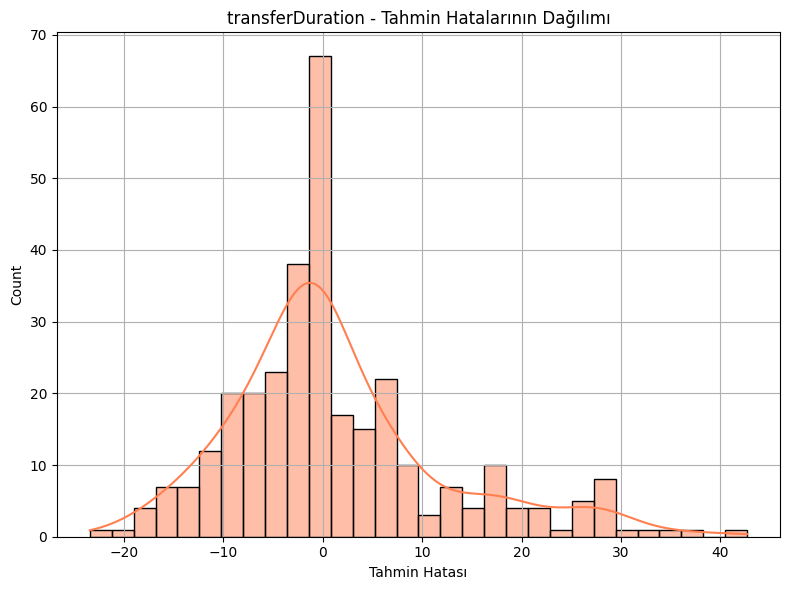

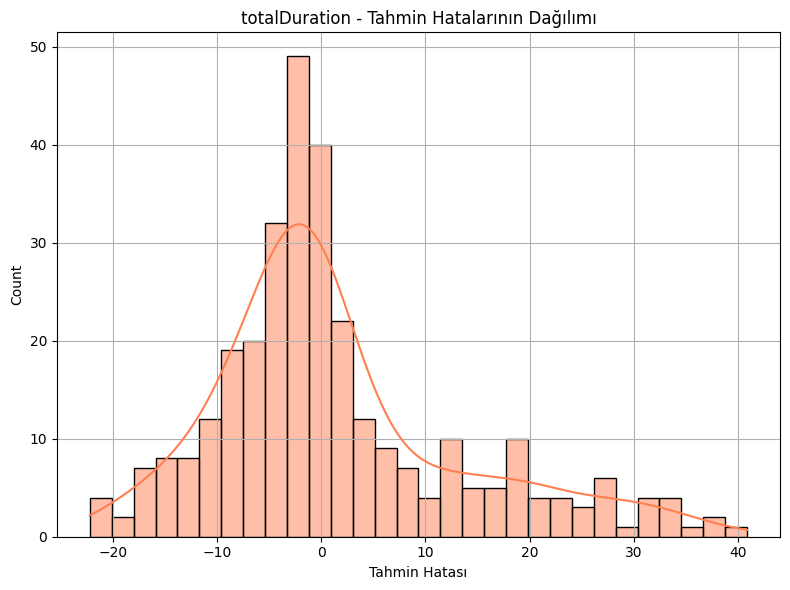

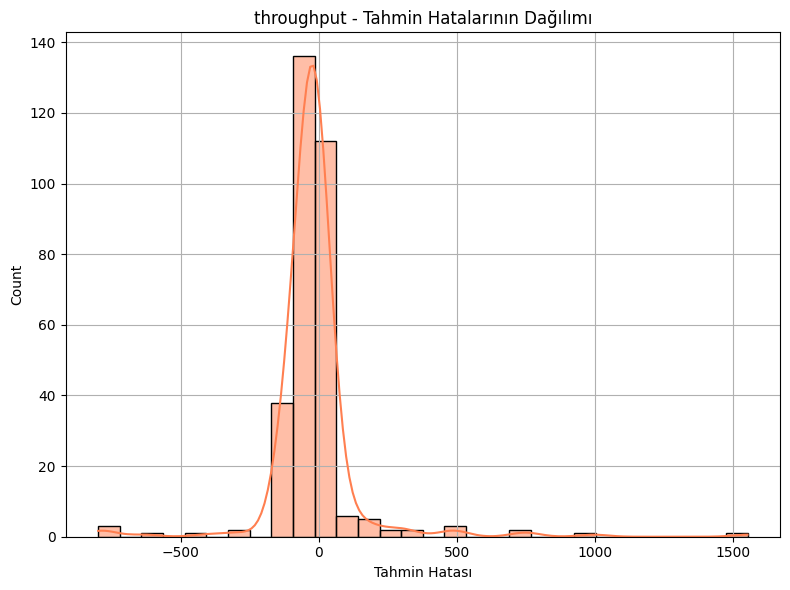

In [ ]:
target_columns = ['durationInMs', 'copyDuration', 'durationInQueue', 'queueDuration', 'transferDuration', 'totalDuration', 'throughput']

errors = y_test.values - y_pred

for i, col in enumerate(target_columns):
    plt.figure(figsize=(8,6))
    sns.histplot(errors[:, i], bins=30, kde=True, color="coral")
    plt.xlabel("Tahmin Hatası")
    plt.title(f"{col} - Tahmin Hatalarının Dağılımı")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Gerçek değerlerle tahmin değerleri arasındaki farkları (hataları) histogram olarak görselleştirir. (normal dağılıma yakın olmalı.)